# Applying a filter to a time-series

This example demonstrates low pass filtering a time-series by applying a weighted running mean over the time dimension.

The time-series used is the Darwin-only Southern Oscillation index (SOI), which is filtered using two different Lanczos filters, one to filter out time-scales of less than two years and one to filter out time-scales of less than 7 years.

## References

- Duchon C. E. (1979) Lanczos Filtering in One and Two Dimensions. Journal of Applied Meteorology, Vol 18, pp 1016-1022.
- Trenberth K. E. (1984) Signal Versus Noise in the Southern Oscillation. Monthly Weather Review, Vol 112, pp 326-332

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt

In [2]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter."""
    order = ((window - 1) // 2) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

Load the monthly-valued Southern Oscillation Index (SOI) time-series.

In [16]:
fname = iris.sample_data_path('SOI_Darwin.nc')
soi = iris.load_cube(fname)

(iris.cube.Cube, <iris 'Cube' of SOI_Darwin / (1) (time: 1776)>)

The `soi` variable is an Iris cube, and we can look at it directly:

In [17]:
soi

Soi Darwin (1),time
Shape,1776
Dimension coordinates,
time,x
Attributes,
Conventions,CF-1.5
reference,Trenberth K. E. (1984) Signal Versus Noise in the Southern Oscillation....
source,http://www.cgd.ucar.edu/cas/catalog/climind/SOI.nc


Set the filter window length

In [4]:
window = 121

Construct 2-year (24-month) and 7-year (84-month) low pass filters for the SOI data which is monthly.

In [14]:
wgts24 = low_pass_weights(window, 1. / 24.)
wgts84 = low_pass_weights(window, 1. / 84.)

Apply each filter using the rolling_window method used with the weights keyword argument. A weighted sum is required because the magnitude of the weights are just as important as their relative sizes.

`soi24` and `soi84` are also Iris cubes.

In [18]:
soi24 = soi.rolling_window('time', iris.analysis.SUM, len(wgts24), weights=wgts24)
soi84 = soi.rolling_window('time', iris.analysis.SUM, len(wgts84), weights=wgts84)

Create some plots of the SOI time series plots and both filtered versions.

Note that the Iris plotting routines (`iplt.plot()`) have some extra functionality, compared to the standard Matplotlib Pyplot routines, in that they understand the Iris cube that is the first argument.

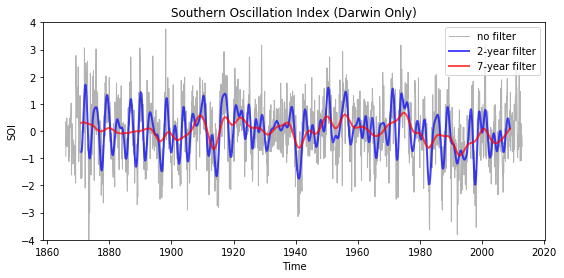

In [24]:
plt.figure(figsize=(9, 4))
iplt.plot(soi, color='0.7', linewidth=1., linestyle='-',
          alpha=1., label='no filter')
iplt.plot(soi24, color='b', linewidth=2., linestyle='-',
          alpha=.7, label='2-year filter')
iplt.plot(soi84, color='r', linewidth=2., linestyle='-',
          alpha=.7, label='7-year filter')
plt.ylim([-4, 4])
plt.title('Southern Oscillation Index (Darwin Only)')
plt.xlabel('Time')
plt.ylabel('SOI')
plt.legend(fontsize=10)
iplt.show()